# Analysis of arXiv'ing effect using Negative Outcome Control (NOC) via Difference-in-Difference (DiD)


v0.1 Jiayao Zhang
June 14, 2023

In [1]:
from __future__ import print_function, absolute_import, division
%load_ext autoreload
%autoreload 2

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7
%env OMP_NUM_THREADS=15
%env OPENBLAS_NUM_THREADS=15
%env OPENMP_NUM_THREADS=15
%env MKL_NUM_THREADS=15
%env HF_HOME=/shared/zjiayao/cache
%env ALLENNLP_CACHE_ROOT=/shared/zjiayao/cache/allennlp


from pathlib import Path
import numpy as np
import pandas as pd
import tqdm
import json
import uuid
import sqlite3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7
env: OMP_NUM_THREADS=15
env: OPENBLAS_NUM_THREADS=15
env: OPENMP_NUM_THREADS=15
env: MKL_NUM_THREADS=15
env: HF_HOME=/shared/zjiayao/cache
env: ALLENNLP_CACHE_ROOT=/shared/zjiayao/cache/allennlp


In [5]:
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

sns.set()
sns.set(font_scale=2.5,)
sns.set_style("white")
# sns.set_style({'font.family': 'Libertine'})
sns.set_palette("colorblind")


plt.rcParams.update({'font.size': 20, 'lines.linewidth':4, 'lines.markersize':12, 
                         'xtick.labelsize':15, 'ytick.labelsize':15, 'axes.labelsize':20,
                         'axes.titlesize': 20, 'legend.fontsize':20,
                         'pdf.fonttype': 42, 'ps.fonttype':42, 
                        'image.interpolation':'nearest', 'figure.figsize': (10,8),
                     "text.usetex": False,
         'text.latex.preamble': r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
                     
                    })
tqdm.tqdm.pandas()


## Load Data

### ICLR Database

See (ICLR Datbse)[https://cogcomp.github.io/iclr_database/] for details of getting the data.

In [7]:
import src.utils as utils
import src.data_utils as data_utils
DATA_PATH = Path('/shared/zjiayao/exp_db')
DB_NAME = "cs_conf_release.db"


In [8]:
db_con = sqlite3.connect(DATA_PATH/DB_NAME)
dataloader = data_utils.DataLoader(db_con, None)

In [10]:
# load tables
sub_reviews_agg = dataloader.get_table('sub_reviews_agg')
sub_derive = dataloader.get_table('sub_derive')
sub_arxiv=dataloader.get_table('submission_arxiv')
author_grp = dataloader.get_table('author_grp')



In [30]:
# aggregate the "design matrix"
design_mat = (sub_reviews_agg # submission-review features
 .merge(sub_derive, on=['submission_id','year']) # derived features from submissions
 .merge(author_grp, on=['submission_id','year','arxiv_first']) # arXiv features
)

# merge with Specter embeddings
# https://www.dropbox.com/s/4cmpoftztj8ajyl/submission_cluster_20.csv?dl=1
design_mat = (design_mat
    .merge(pd.read_csv(DATA_PATH / 'submission_cluter_20.csv')[['submission_id','cluster']],
           on='submission_id', how='left')
)

In [ ]:
# internal use only
baby_iclr=(design_mat[['submission_id','year','full_decision','arxiv_first',]]
 .merge(subs[['submission_id','title','authors','keywords','tldr']],
       on='submission_id',how='left')
 .merge(sub_arxiv[['submission_id','arxiv_id','primary_category',
                  'published_time','updated_time']], on='submission_id', how='left')
)

### S2 Citation Data (NCO)

In [33]:
# here the example is 1-year, 3-year, and 5-year (dropping NA rows)
# change the path accordingly
import functools
citation_data_path = [
    ('c365', './c_365.csv', ','),
    ('c1095', './c_1095.tsv', '\t'),
    ('c1825', './c_1825.tsv', '\t')
]

cites_within_window = functools.reduce(
    lambda x,y: x.merge(y,on=['submission_id'], how='outer'),
    [(pd.read_csv(p, sep=s)
      .rename({'cites_within_year':l,'cites_within_window':l},axis=1,errors='ignore')
      [['submission_id',l]]
     )
     for l, p, s in citation_data_path],
)


In [34]:
design_mat = design_mat.merge(cites_within_window, on='submission_id', how='outer')

## Prepare Data for Matching

In [78]:
# log transform some columns
design_mat['log_input_len'] = np.log10(design_mat['input_len'])
design_mat['log_ins_rank_min'] = np.log10(design_mat['ins_rank_min'])
design_mat['log_ins_rank_avg'] = np.log10(design_mat['ins_rank_avg'])
design_mat['log_ins_rank_max'] = np.log10(design_mat['ins_rank_max'])
design_mat['log_author_cite_max'] = np.log10(1+design_mat['author_cite_max'])
design_mat['log_author_cite_avg'] = np.log10(1+design_mat['author_cite_avg'])
design_mat['log_author_cite_min'] = np.log10(1+design_mat['author_cite_min'])

In [79]:
Ns = ['c365', 'c1095', 'c1825']
A = 'arxiv_first'
Y = 'binary_decision'
C_cols = ['year',
 'log_input_len',
 'n_fig',
 'n_ref',
 'n_sec',
 'sub_fluency',
 'cluster',
 'n_author',
 'fst_reported_f',
 'any_reported_f',
 'cnt_reported_f',
 'demo_no_us',
 'log_ins_rank_min',
 'log_ins_rank_avg',
 'log_ins_rank_max',
 'log_author_cite_min',
 'log_author_cite_avg',
 'log_author_cite_max'
]

C_vars = ['C(year)',
 'log_input_len',
 'n_fig',
 'n_ref',
 'n_sec',
 'sub_fluency',
 'C(cluster)',
 'n_author',
 'C(fst_reported_f)',
 'C(any_reported_f)',
 'cnt_reported_f',
 'C(demo_no_us)',
 'log_ins_rank_min',
 'log_ins_rank_avg',
 'log_ins_rank_max',
 'log_author_cite_min',
 'log_author_cite_avg',
 'log_author_cite_max'
]

In [99]:
## remove NAs in covariates
design_mat = design_mat[~design_mat[C_cols].isna().any(axis=1)]

In [100]:
design_mat.to_csv('./design_mat.csv',header=True,index=False)

In [103]:
## (optional) create cosine-similarity matrix
# emb_df = pd.read_csv(DATA_PATH / 'submission_specter_embedding.csv')
# utils.lit_eval_df(emb_df, ['encoded_vec'])

In [160]:
## load back matched df

In [162]:
def load_matched_df(path, df):
    matched_design_mat = pd.read_csv(path).drop('Unnamed: 0',axis=1)
    matched_design_mat=matched_design_mat[~matched_design_mat.matched_set.isna()]
    return pd.concat([
        matched_design_mat.iloc[::2].assign(grp='treated'),
        matched_design_mat.iloc[1::2].assign(grp='control'),]
    )

#### Matched Data
1. https://www.dropbox.com/s/1y75t3mw6a70aj1/fb_matched_design_mat_ordered.csv?dl=0
2. https://www.dropbox.com/s/4fl3wa4wq15zqwr/matched_design_mat_ordered.csv?dl=0

In [ ]:
## without fine-balance
matched_dat = load_matched_df('matched_design_mat_ordered.csv', design_mat)

## with fine-balance
fb_matched_dat = load_matched_df('fb_matched_design_mat_ordered.csv', design_mat)

### Table One

In [147]:
import tableone
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [174]:
def constrcut_tableone(matched, df):
    matched = pd.concat([matched,
            df[~df.arxiv_first].assign(grp='unmatched')]
    )[C_cols+['grp']]

    return tableone.TableOne(pd.concat([matched,
                                      df[~df.arxiv_first].assign(grp='unmatched')]
                            )[C_cols+['grp']].reset_index(), #.assign(grpi=lambda s:s['grp']).set_index(['grpi','submission_id']),
                           categorical=['cluster','demo_no_us','fst_reported_f', 'any_reported_f'],
                           groupby=['grp'],
                           pval=True
    )

In [175]:
t1_matched = constrcut_tableone(matched_dat,design_mat)

t1_fb_matched = constrcut_tableone(fb_matched_dat,design_mat)

In [182]:
t1_matched

Grouped by grp                                                                          
                                            Missing          Overall         control         treated        unmatched P-Value
n                                                              17958            1486            1486            14986        
index, mean (SD)                                  0  4504.2 (3053.8)  1486.0 (858.2)  1485.0 (858.2)  5102.8 (2977.2)  <0.001
year, mean (SD)                                   0     2020.4 (1.4)    2020.8 (0.9)    2020.8 (0.9)     2020.3 (1.5)  <0.001
log_input_len, mean (SD)                          0        4.0 (0.2)       4.0 (0.2)       4.0 (0.2)        4.0 (0.2)  <0.001
n_fig, mean (SD)                                  0       12.9 (7.6)      14.4 (9.4)      14.3 (7.5)       12.6 (7.3)  <0.001
n_ref, mean (SD)                                  0      41.5 (17.2)     44.4 (19.8)     44.7 (16.7)      40.9 (16.9)  <0.001
n_sec, mean (SD)                                  0       19.5 (7.3)      20.7 (7.9)      20.8 (7.8)       19.2 (7.1)  <0.001
sub_fluency, mean (SD)                            0        0.8 (0.0)       0.8 (0.0)       0.8 (0.0)        0.8 (0.0)  <0.001
cluster, n (%)                 0                  0        808 (4.5)        81 (5.5)        77 (5.2)        650 (4.3)  <0.001
                               1                           931 (5.2)        81 (5.5)        66 (4.4)        784 (5.2)        
                               10                         1300 (7.2)       106 (7.1)       108 (7.3)       1086 (7.2)        
                               11                          972 (5.4)       104 (7.0)        94 (6.3)        774 (5.2)        
                               12                         1096 (6.1)        99 (6.7)        87 (5.9)        910 (6.1)        
                               13                          672 (3.7)        45 (3.0)        49 (3.3)        578 (3.9)        
                               14                          757 (4.2)        45 (3.0)        48 (3.2)        664 (4.4)        
                               15                          634 (3.5)        42 (2.8)        44 (3.0)        548 (3.7)        
                               16                          593 (3.3)        50 (3.4)        41 (2.8)        502 (3.3)        
                               17                          686 (3.8)        44 (3.0)        50 (3.4)        592 (4.0)        
                               18                          707 (3.9)        52 (3.5)        57 (3.8)        598 (4.0)        
                               19                          701 (3.9)        69 (4.6)        66 (4.4)        566 (3.8)        
                               2                           533 (3.0)        41 (2.8)        46 (3.1)        446 (3.0)        
                               3                           794 (4.4)        59 (4.0)        55 (3.7)        680 (4.5)        
                               4                          1260 (7.0)       130 (8.7)       140 (9.4)        990 (6.6)        
                               5                          1126 (6.3)       104 (7.0)       106 (7.1)        916 (6.1)        
                               6                           894 (5.0)        81 (5.5)        87 (5.9)        726 (4.8)        
                               7                          1751 (9.8)       118 (7.9)       129 (8.7)      1504 (10.0)        
                               8                           667 (3.7)        63 (4.2)        62 (4.2)        542 (3.6)        
                               9                          1076 (6.0)        72 (4.8)        74 (5.0)        930 (6.2)        
n_author, mean (SD)                               0        4.3 (2.0)       4.1 (1.8)       4.2 (1.9)        4.3 (2.0)  <0.001
fst_reported_f, n (%)          False              0     16487 (91.8)     1388 (93.4)     1399 (94.1)     13700 (91.4)  <0.001
     

In [183]:
t1_fb_matched

Grouped by grp                                                                          
                                            Missing          Overall         control         treated        unmatched P-Value
n                                                              17958            1486            1486            14986        
index, mean (SD)                                  0  4504.2 (3053.8)  1486.0 (858.2)  1485.0 (858.2)  5102.8 (2977.2)  <0.001
year, mean (SD)                                   0     2020.4 (1.4)    2020.8 (0.9)    2020.8 (0.9)     2020.3 (1.5)  <0.001
log_input_len, mean (SD)                          0        4.0 (0.2)       4.0 (0.2)       4.0 (0.2)        4.0 (0.2)  <0.001
n_fig, mean (SD)                                  0       12.9 (7.6)      14.4 (9.4)      14.3 (7.5)       12.6 (7.3)  <0.001
n_ref, mean (SD)                                  0      41.5 (17.2)     44.4 (19.8)     44.7 (16.7)      40.9 (16.9)  <0.001
n_sec, mean (SD)                                  0       19.5 (7.3)      20.7 (7.9)      20.8 (7.8)       19.2 (7.1)  <0.001
sub_fluency, mean (SD)                            0        0.8 (0.0)       0.8 (0.0)       0.8 (0.0)        0.8 (0.0)  <0.001
cluster, n (%)                 0                  0        808 (4.5)        81 (5.5)        77 (5.2)        650 (4.3)  <0.001
                               1                           931 (5.2)        81 (5.5)        66 (4.4)        784 (5.2)        
                               10                         1300 (7.2)       106 (7.1)       108 (7.3)       1086 (7.2)        
                               11                          972 (5.4)       104 (7.0)        94 (6.3)        774 (5.2)        
                               12                         1096 (6.1)        99 (6.7)        87 (5.9)        910 (6.1)        
                               13                          672 (3.7)        45 (3.0)        49 (3.3)        578 (3.9)        
                               14                          757 (4.2)        45 (3.0)        48 (3.2)        664 (4.4)        
                               15                          634 (3.5)        42 (2.8)        44 (3.0)        548 (3.7)        
                               16                          593 (3.3)        50 (3.4)        41 (2.8)        502 (3.3)        
                               17                          686 (3.8)        44 (3.0)        50 (3.4)        592 (4.0)        
                               18                          707 (3.9)        52 (3.5)        57 (3.8)        598 (4.0)        
                               19                          701 (3.9)        69 (4.6)        66 (4.4)        566 (3.8)        
                               2                           533 (3.0)        41 (2.8)        46 (3.1)        446 (3.0)        
                               3                           794 (4.4)        59 (4.0)        55 (3.7)        680 (4.5)        
                               4                          1260 (7.0)       130 (8.7)       140 (9.4)        990 (6.6)        
                               5                          1126 (6.3)       104 (7.0)       106 (7.1)        916 (6.1)        
                               6                           894 (5.0)        81 (5.5)        87 (5.9)        726 (4.8)        
                               7                          1751 (9.8)       118 (7.9)       129 (8.7)      1504 (10.0)        
                               8                           667 (3.7)        63 (4.2)        62 (4.2)        542 (3.6)        
                               9                          1076 (6.0)        72 (4.8)        74 (5.0)        930 (6.2)        
n_author, mean (SD)                               0        4.3 (2.0)       4.1 (1.8)       4.2 (1.9)        4.3 (2.0)  <0.001
fst_reported_f, n (%)          False              0     16487 (91.8)     1388 (93.4)     1399 (94.1)     13700 (91.4)  <0.001
     

**TLDR**  Matched okay, no need to additionaly matched on specter cosine similarty and/or adding fine-balance on topic cluster

## DiD with NOC

### Sanity Check:
NB regression for NOC

In [49]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [80]:
C_formula = '+'.join(C_vars)
formula = f"{A} + " + C_formula

In [83]:
reg_noc = [smf.ols(formula=f"np.log10(1+{n}) ~ {formula}", data=design_mat).fit() for n in Ns]

In [88]:
# note that arxiv_first is significant
reg_noc[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     np.log10(1 + c365)   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     43.03
Date:                Sun, 18 Jun 2023   Prob (F-statistic):          8.07e-305
Time:                        20:17:09   Log-Likelihood:                -4696.6
No. Observations:                7097   AIC:                             9477.
Df Residuals:                    7055   BIC:                             9766.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.4811      0.305     -4.860      0.000      -2.078      -0.884
arxiv_first[T.True]           0.0710      0.015      4.758      0.000       0.042       0.100
C(year)[T.2018]              -0.0962      0.030     -3.154      0.002      -0.156      -0.036
C(year)[T.2019]              -0.2807      0.029     -9.764      0.000      -0.337      -0.224
C(year)[T.2020]              -0.3361      0.028    -11.965      0.000      -0.391      -0.281
C(year)[T.2021]              -0.2854      0.033     -8.713      0.000      -0.350      -0.221
C(year)[T.2022]              -0.3910      0.030    -13.043      0.000      -0.450      -0.332
C(cluster)[T.1]               0.0309      0.037      0.838      0.402      -0.041       0.103
C(cluster)[T.2]               0.0983      0.043      2.291      0.022       0.014       0.182
C(cluster)[T.3]               0.0218      0.039      0.563      0.574      -0.054       0.098
C(cluster)[T.4]               0.1255      0.034      3.645      0.000       0.058       0.193
C(cluster)[T.5]               0.1837      0.036      5.138      0.000       0.114       0.254
C(cluster)[T.6]               0.2178      0.037      5.821      0.000       0.144       0.291
C(cluster)[T.7]              -0.0005      0.033     -0.014      0.989      -0.065       0.064
C(cluster)[T.8]               0.1644      0.041      4.051      0.000       0.085       0.244
C(cluster)[T.9]               0.0468      0.036      1.313      0.189      -0.023       0.117
C(cluster)[T.10]              0.2083      0.035      5.962      0.000       0.140       0.277
C(cluster)[T.11]              0.1841      0.038      4.875      0.000       0.110       0.258
C(cluster)[T.12]              0.0759      0.037      2.079      0.038       0.004       0.148
C(cluster)[T.13]              0.0864      0.039      2.193      0.028       0.009       0.164
C(cluster)[T.14]              0.0887      0.039      2.274      0.023       0.012       0.165
C(cluster)[T.15]              0.0551      0.041      1.349      0.177      -0.025       0.135
C(cluster)[T.16]              0.0189      0.041      0.458      0.647      -0.062       0.100
C(cluster)[T.17]              0.1925      0.040      4.816      0.000       0.114       0.271
C(cluster)[T.18]              0.1041      0.039      2.673      0.008       0.028       0.180
C(cluster)[T.19]              0.0685      0.041      1.686      0.092      -0.011       0.148
C(fst_reported_f)[T.True]    -0.0270      0.024     -1.136      0.256      -0.074       0.020
C(any_reported_f)[T.True]    -0.0191      0.029     -0.654      0.513      -0.076       0.038
C(demo_no_us)[T.True]        -0.0228      0.015     -1.505      0.132      -0.052       0.007
log_input_len                 0.2370      0.041      5.810      0.000      

**TLDR** NCO is associated with treatment variable.

## Studies

In [215]:
def get_ci_by_level(df, y, formula, level_col, level_vars, level_lb, grp_name='level', alpha=0.05):
    mus = []
    models = []
    for lv, lb in zip([None,]+level_vars, ['all',]+level_lb):
        dat = df[df[level_col] == lv] if lv is not None else df

        did_dichi = smf.ols(
            formula=f"{y} ~ {formula}".strip(),
            data=dat,
        ).fit()
        models.append(did_dichi)
        mus.append(pd.DataFrame([np.hstack(
            [[lb], [float(did_dichi.pvalues.iloc[1])],[did_dichi.params.iloc[1]], 
             did_dichi.conf_int(alpha).iloc[1].values])],
            columns=['var','pval','r','ll','hl'])
                  )

    mus=pd.concat(mus).assign(grp=grp_name)
    mus['pval']=mus['pval'].values.astype(float)
    return mus, models

In [ ]:
## define NCO and prepare for DiD
NCOs = ['N1', 'N2', 'N3']
design_mat = design_mat.reset_index()
design_mat['N1'] = design_mat[Y] - 1.*(design_mat['c365']>=10)
design_mat['N2'] = design_mat[Y] - 1.*(design_mat['c1095']>=100)
design_mat['N3'] = design_mat[Y] - 1.*(design_mat['c1825']>=500)


In [197]:
design_mat['inst_level'] =\
    design_mat['log_ins_rank_min'].apply(lambda s : 'L' if s < 1 else ('M' if s < 2 else 'H')
)

design_mat['author_level'] =\
    design_mat['log_author_cite_avg'].apply(lambda s : 'L' if s < 2 else ('M' if s < 4 else 'H')
)



In [201]:
dat = matched_dat.merge(
    design_mat[['submission_id','inst_level','author_level']+NCOs], 
    on='submission_id', 
    how='left')



In [203]:
inst_formula = f"{A} + " + '+'.join([var for var in C_vars if 'inst_rank' not in var])
author_formula = f"{A} + " + '+'.join([var for var in C_vars if 'author_cite' not in var])

### Plots

In [239]:
import forestplot as fp
def forest_plot(mus, title, plt=plt):
    plt.figure(figsize=(4,6), dpi=150)
    ax=plt.gca()
    ax=fp.forestplot(mus,  # the dataframe with results data
                  estimate="r",  # col containing estimated effect size 
                  ll="ll", hl="hl",  # columns containing conf. int. lower and higher limits
                  varlabel="var",  # column containing variable label
                  groupvar='grp',
                  pval='pval',
                  ylabel="95% Confidence Interval",  # y-label title
                  xlabel="Estimated ATET",  # x-label title
                     ax=ax,
#                   ci_report=False,
                  )
    plt.suptitle(title)

#### 1. $N = 1\{\text{1-year cite} > 10 \}$

In [269]:
print(len(dat))

2972


In [255]:
n1_inst = get_ci_by_level(dat, y='N1', formula=inst_formula,
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['top-10', '10-100', 'others'], grp_name='Min Inst Rank'
)

n1_author = get_ci_by_level(dat, y='N1', formula=author_formula,
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['<100', '100-10000', '>10000'], grp_name='Max Author Citation'
                           )

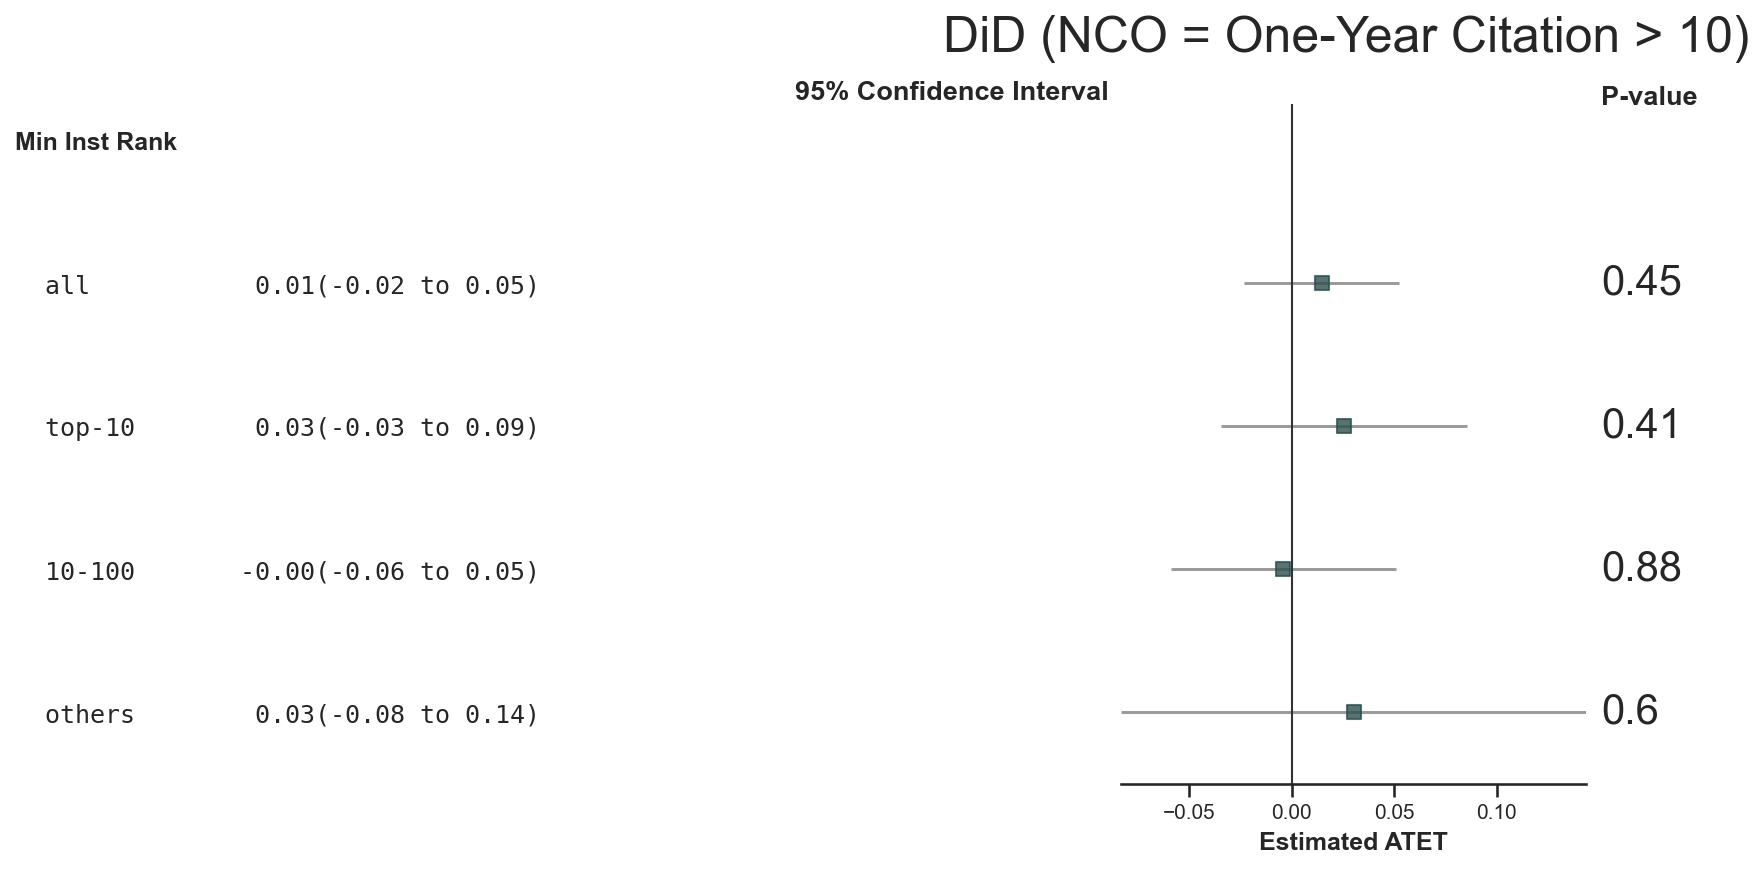

In [249]:
forest_plot(n1_inst[0], 
            'DiD (NCO = One-Year Citation > 10)')

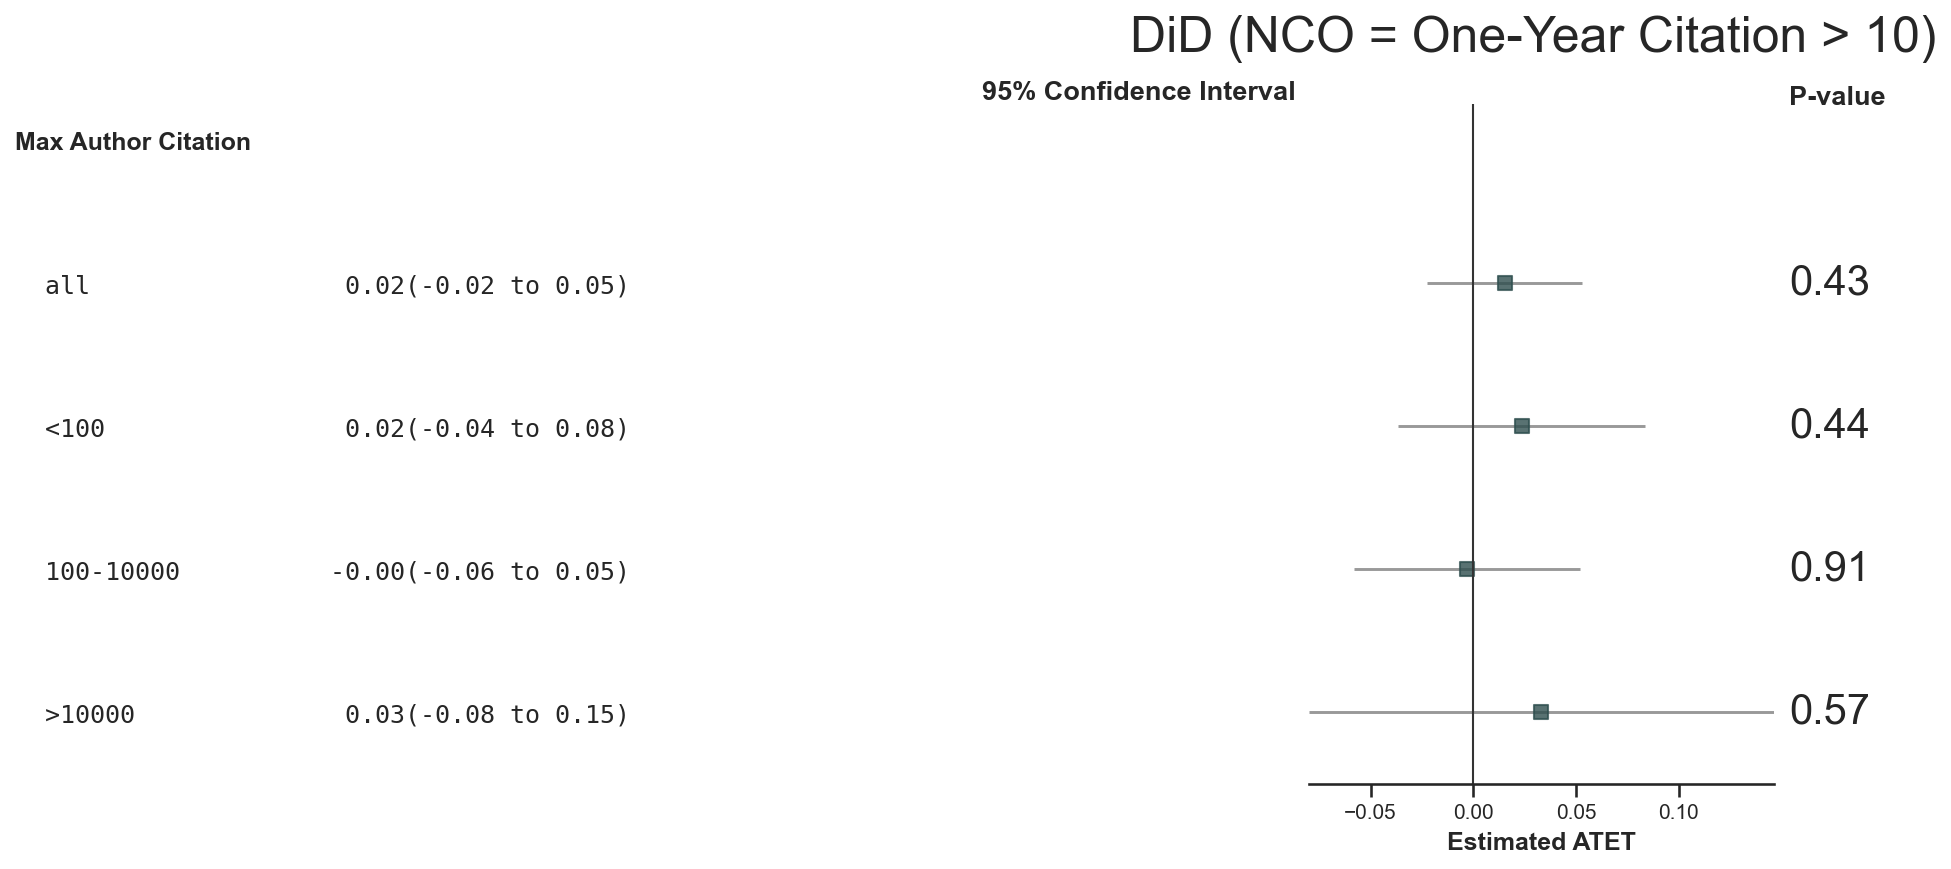

In [250]:
forest_plot(n1_author[0], 
            'DiD (NCO = One-Year Citation > 10)')

#### 2. $N = 1\{\text{2-year cite} > 100 \}$

In [265]:
print(len(dat[dat.year<=2020]))

1141


In [266]:
n2_inst = get_ci_by_level(dat[dat.year<=2020], y='N2', formula=inst_formula,
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['top-10', '10-100', 'others'], grp_name='Min Inst Rank'
)

n2_author = get_ci_by_level(dat[dat.year<=2020], y='N2', formula=author_formula,
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['<100', '100-10000', '>10000'], grp_name='Max Author Citation'
                           )

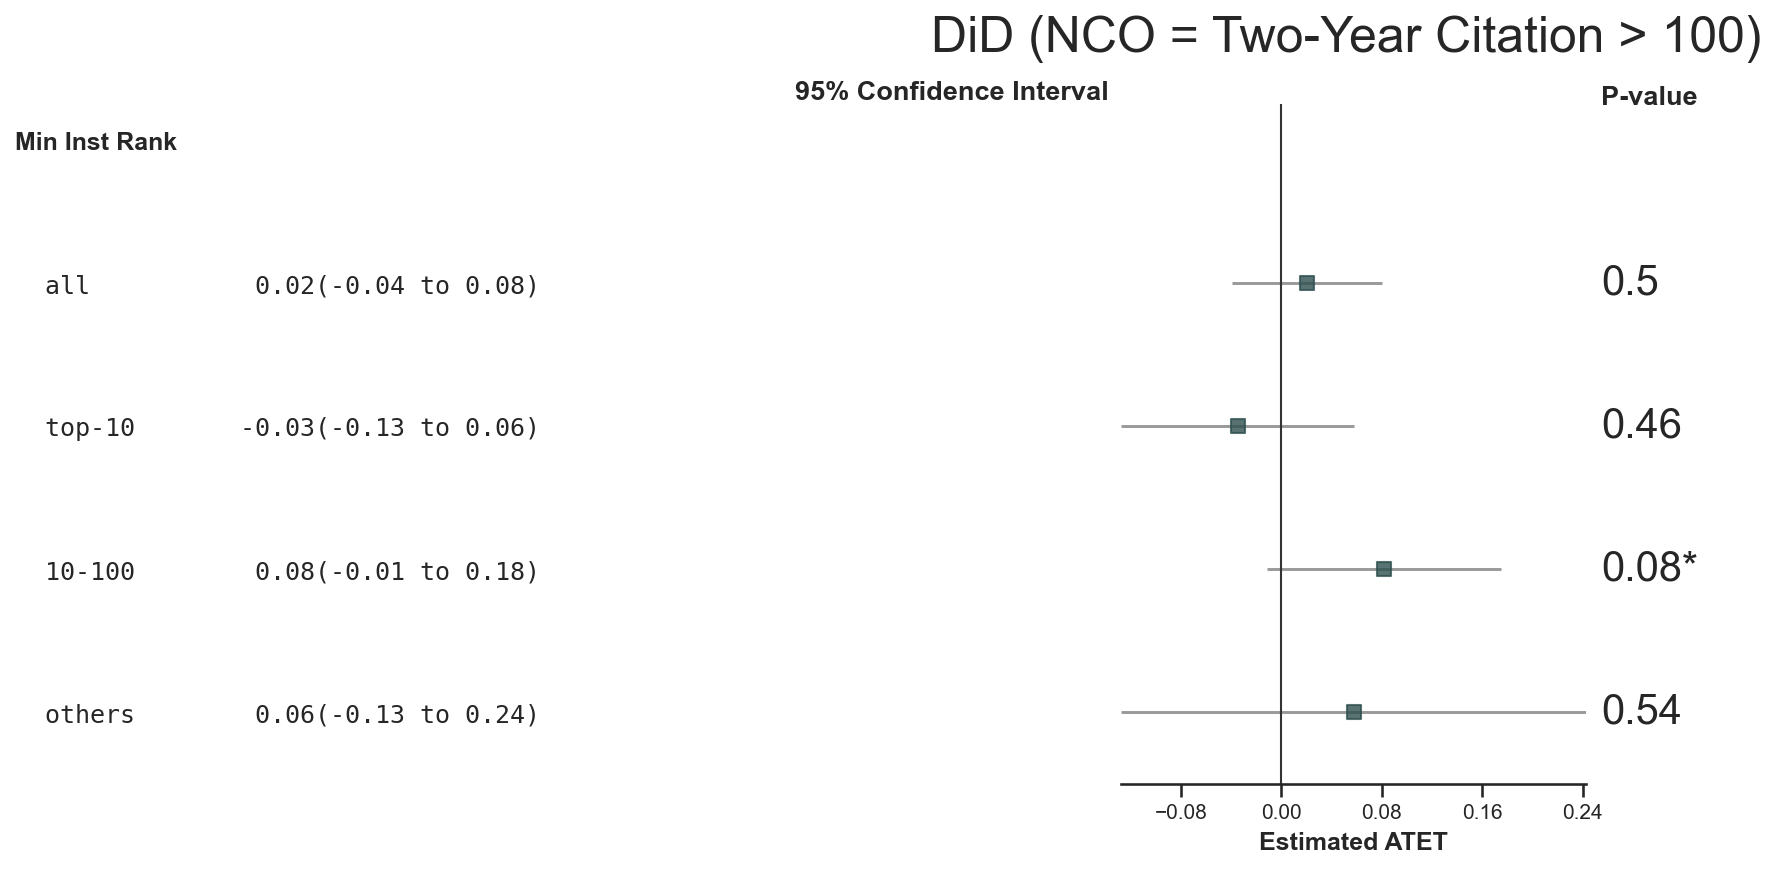

In [267]:
forest_plot(n2_inst[0],
            'DiD (NCO = Two-Year Citation > 100)')

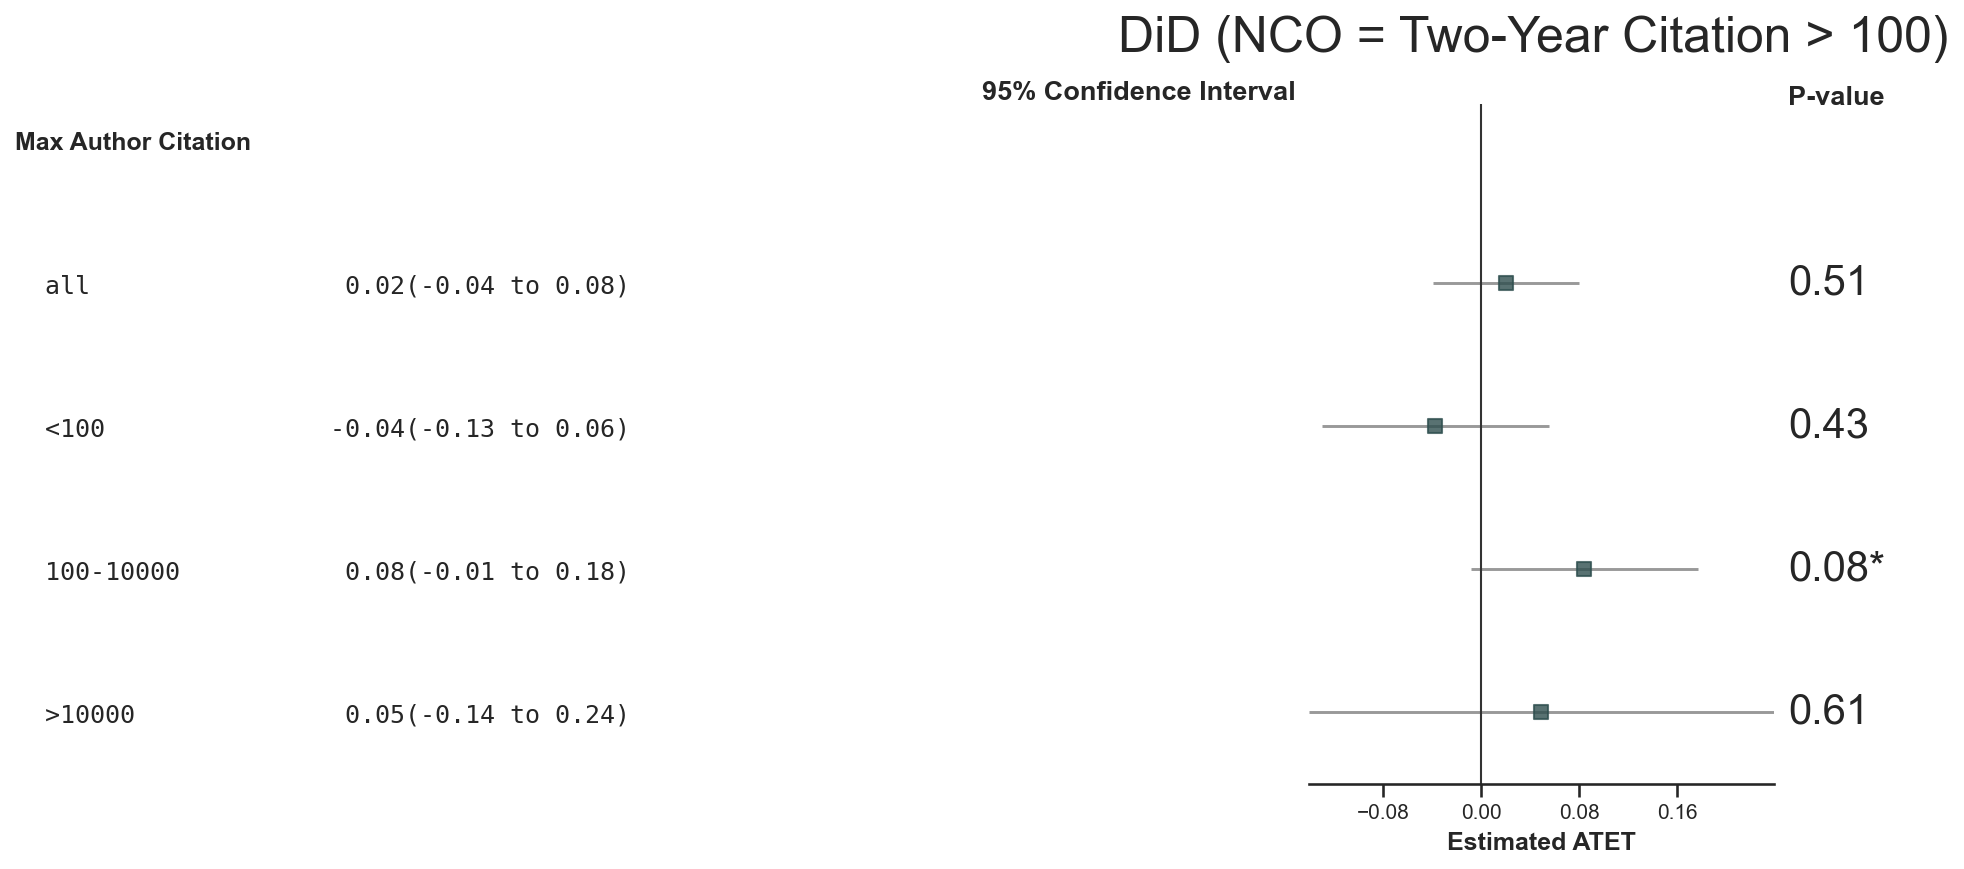

In [268]:
forest_plot(n2_author[0], 
            'DiD (NCO = Two-Year Citation > 100)')

#### 3. $N = 1\{\text{5-year cite} > 500 \}$

In [263]:
# too few data point!
print(len(dat[dat.year<=2018]))

40


In [258]:
n3_inst = get_ci_by_level(dat[dat.year<=2018], y='N2', formula=inst_formula,
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['top-10', '10-100', 'others'], grp_name='Min Inst Rank'
)

n3_author = get_ci_by_level(dat[dat.year<=2018], y='N2', formula=author_formula,
                          level_col='inst_level', level_vars=['L','M','H'],
                          level_lb=['<100', '100-10000', '>10000'], grp_name='Max Author Citation'
                           )

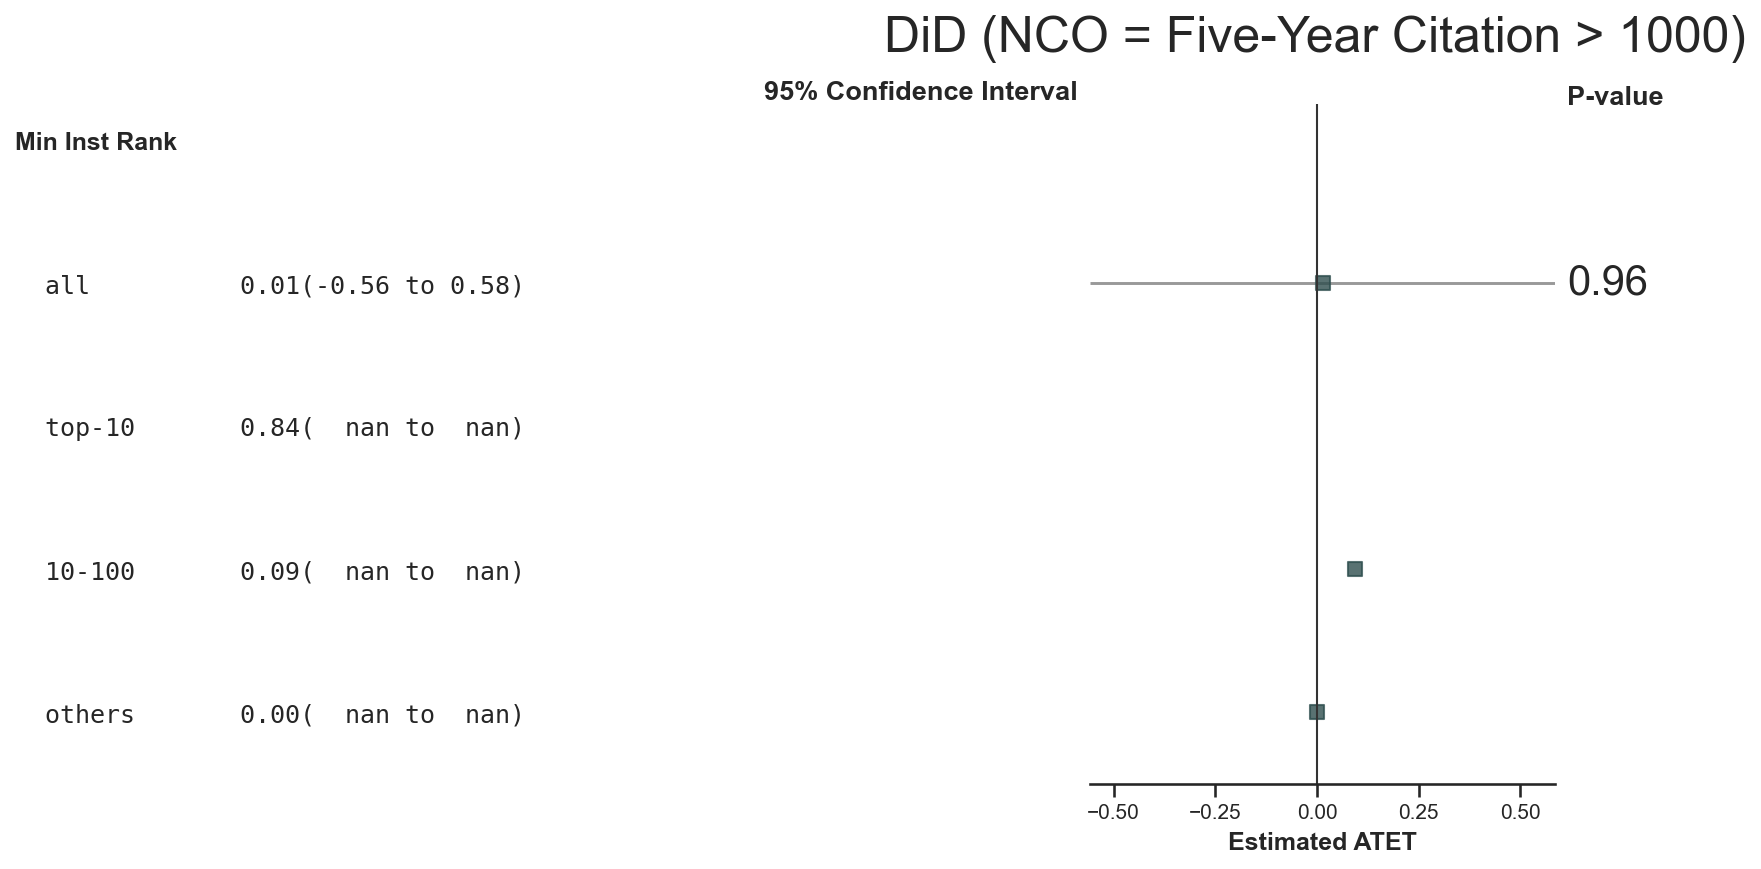

In [259]:
forest_plot(n3_inst[0],
            'DiD (NCO = Five-Year Citation > 1000)')

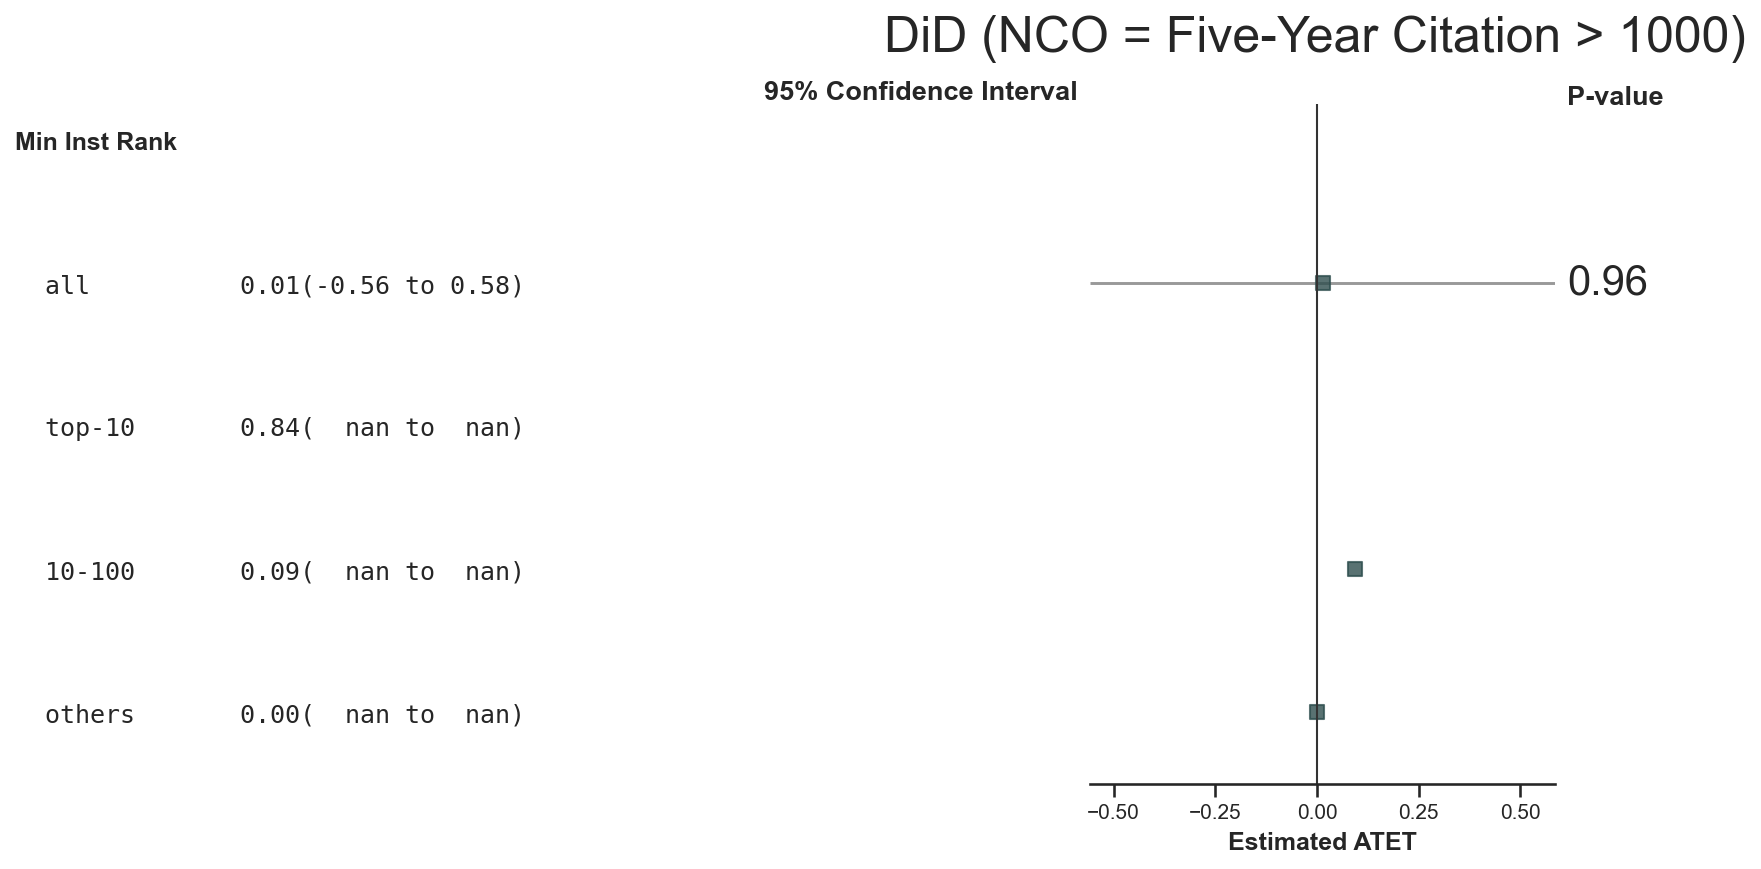

In [260]:
forest_plot(n3_inst[0],
            'DiD (NCO = Five-Year Citation > 1000)')